### opened a new dataframe

In [8]:
import pandas as pd

combined_df = pd.read_csv("df12.csv")
combined_df.drop(columns = ['Unnamed: 0', 'index'], inplace = True)
combined_df

,restaurant,type,name,description
0,Steve poke,Signature Bowls,No Swimmin' Bowl,"Vegetarian. tofu, furikake seasoning, corn, ed..."
1,Steve poke,Signature Bowls,A Shore Thing Bowl,"Spicy mayo scallops, furikake seasoning, tobik..."
2,Steve poke,Signature Bowls,Shoyu A Good Time Bowl,"Shoyu ahi tuna, furikake seasoning, tobiko, co..."
3,Steve poke,Signature Bowls,Toona Spicy Bowl,"Spicy mayo ahi tuna, furikake seasoning, tobik..."
4,Steve poke,Signature Bowls,California Dreamin’ Bowl,"Shoyu salmon, furikake seasoning, tobiko, corn..."
...,...,...,...,...
3588,Olde Yorke Fish & Chips,DRINKS,Ice Tea,NaN
3589,Olde Yorke Fish & Chips,DRINKS,Orange Juice,NaN
3590,Olde Yorke Fish & Chips,DRINKS,Bottle Water,NaN
3591,Olde Yorke Fish & Chips,DRINKS,Apple Juice,NaN


### dropped Nan values

In [9]:
combined_df = combined_df.dropna()
combined_df.reset_index(inplace=True, drop=True)
combined_df

,restaurant,type,name,description
0,Steve poke,Signature Bowls,No Swimmin' Bowl,"Vegetarian. tofu, furikake seasoning, corn, ed..."
1,Steve poke,Signature Bowls,A Shore Thing Bowl,"Spicy mayo scallops, furikake seasoning, tobik..."
2,Steve poke,Signature Bowls,Shoyu A Good Time Bowl,"Shoyu ahi tuna, furikake seasoning, tobiko, co..."
3,Steve poke,Signature Bowls,Toona Spicy Bowl,"Spicy mayo ahi tuna, furikake seasoning, tobik..."
4,Steve poke,Signature Bowls,California Dreamin’ Bowl,"Shoyu salmon, furikake seasoning, tobiko, corn..."
...,...,...,...,...
2074,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Caesar Salad (Large),"Romaine Lettuce, Caesar Dressing, Croutons, Pa..."
2075,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Cioppino,"A tomato base broth with scallops, prawns, cla..."
2076,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Oyster Pepper Stew,A tomato base with red & green peppers
2077,Olde Yorke Fish & Chips,SHELLFISH,Clams (1 Ib),Steamed in white wine with chopped tomato & on...


In [10]:
#Install necessary modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
import pickle
from nltk.corpus import stopwords
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

nlp = spacy.load("en_core_web_lg")
model_name = 'bert-base-nli-mean-tokens'

kanji = re.compile('[ぁ-んァ-ン一-龥]+')

#cleaning the data
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()    #using lemmatization

model = SentenceTransformer(model_name)

import pickle

In [ ]:
def clean(text):
    stop_free = ' '.join([word for word in text.lower().split() if word not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    kanji_free = ''.join(ch1 for ch1 in punc_free if ch1 not in kanji.findall(ch1))
    normalized = ' '.join([lemma.lemmatize(word) for word in kanji_free.split()])
    return normalized

In [ ]:
def getPipelineToken() -> dict:
    reqUrl = "https://machinelearningauth.v2.dyneapp.ca/request-pipeline-token"
    headersList = {
        "Accept": "*/*"
    }
    payload = ""
    response = requests.request("GET", reqUrl, data=payload,  headers=headersList)
    return response.json()

In [ ]:
def searchPipelineRequest(search: str, token: str) -> dict:
    " You now need the bearer access token from PipelineAuthFunc to access the existing endpoints."
    reqUrl = "https://pipeline-ms.v2.dyneapp.ca/mealme-restaurant"
    headersList = {
        "Accept": "*/*",
        "Authorization": "Bearer {}".format(token), # TODO: YOU NOW NEED TO ADD THIS LINE TO ALL REQUESTS
        "Content-Type": "application/json"
    }
    payload = json.dumps({
        "search": str(search)
    })
    response = requests.request("POST", reqUrl, data=payload,  headers=headersList)
    return response.json()

In [ ]:
#getting data from dyne api
def get_data_from_api():
    token = getPipelineToken()
    restaurant = ['De Dutch Pannekoek House', 'Little Sister Dutch Indonesian']
    data = []
    for i in restaurant:
        all_data = searchPipelineRequest(i, token['access_token'])
        df1 = pd.DataFrame(all_data)
        df1 = pd.DataFrame(df1['menu']['categories'])
        menu_item_list = [item for i in df1.menu_item_list for item in i]
        data.extend([{'restaurant': i, 'name': item['name'],'description': item['description']} for item in menu_item_list])
    combined_df = pd.DataFrame(data)
    return combined_df

### data preprocessing (Dyne api and Cliant)

In [ ]:
#preprocessing the dataframe
def preprocess_data(combined_df, combined_df_cli):

    combined_df = combined_df.dropna()
    combined_df.reset_index(inplace=True, drop=True)
    
    combined_df['type + name + description']=combined_df['type'] +' : '+ combined_df['name'] +' : '+ combined_df['description']
    combined_df["Description - Name"] = combined_df.apply(lambda row: ' '.join([word for word in row["description"].lower().split() if word not in row["name"].lower().split()]), axis=1)
    combined_df["Description - Name - Type"] = combined_df.apply(lambda row: ' '.join([word for word in row["Description - Name"].lower().split() if word not in row["type"].lower().split()]), axis=1)
    combined_df['type + name + description_c']=combined_df['type + name + description'].apply(clean)
    combined_df['Description - Name - Type_c']=combined_df['Description - Name - Type'].apply(clean)
    
    combined_df_cli = combined_df_cli.dropna()
    combined_df_cli.reset_index(inplace=True, drop=True)
    
    combined_df_cli['type + name + description']=combined_df_cli['type'] +' : '+ combined_df_cli['name'] +' : '+ combined_df_cli['description']
    combined_df_cli["Description - Name"] = combined_df_cli.apply(lambda row: ' '.join([word for word in row["description"].lower().split() if word not in row["name"].lower().split()]), axis=1)
    combined_df_cli["Description - Name - Type"] = combined_df_cli.apply(lambda row: ' '.join([word for word in row["Description - Name"].lower().split() if word not in row["type"].lower().split()]), axis=1)
    combined_df_cli['type + name + description_c']=combined_df_cli['type + name + description'].apply(clean)
    combined_df_cli['Description - Name - Type_c']=combined_df_cli['Description - Name - Type'].apply(clean)
    
    return combined_df, combined_df_cli

# Encoding

In [ ]:
def encoding(combined_df, combined_df_cli):
    
    sentences1 = (combined_df['type + name + description'][0:])
    sentences1=sentences1.to_list()
    
    sentences2 = (combined_df['Description - Name - Type'][0:])
    sentences2=sentences2.to_list()
    
    sentences3 = (combined_df['type + name + description_c'][0:])
    sentences3=sentences3.to_list()
    
    sentences4 = (combined_df['Description - Name - Type_c'][0:])
    sentences4=sentences4.to_list()
    
    sentences1_c = (combined_df_cli['type + name + description'][0:])
    sentences1_c=sentences1_c.to_list()

    sentences2_c = (combined_df_cli['Description - Name - Type'][0:])
    sentences2_c=sentences2_c.to_list()

    sentences3_c = (combined_df_cli['type + name + description_c'][0:])
    sentences3_c=sentences3_c.to_list()

    sentences4_c = (combined_df_cli['Description - Name - Type_c'][0:])
    sentences4_c=sentences4_c.to_list()
    
    sentence1_vecs = model.encode(sentences1)
    sentence2_vecs = model.encode(sentences2)
    sentence3_vecs = model.encode(sentences3)
    sentence4_vecs = model.encode(sentences4)
    sentence1_c_vecs = model.encode(sentences1_c)
    sentence2_c_vecs = model.encode(sentences2_c)
    sentence3_c_vecs = model.encode(sentences3_c)
    sentence4_c_vecs = model.encode(sentences4_c)
    
    return　sentence1_vecs, sentence2_vecs, sentence3_vecs, sentence4_vecs, sentence1_c_vecs, sentence2_c_vecs, sentence3_c_vecs, sentence4_c_vecs
    
    

# Calculation of similarity to client menu

In [ ]:
def calculation_similarity(sentence1_vecs, 
                           sentence2_vecs, 
                           sentence3_vecs, 
                           sentence4_vecs, 
                           sentence1_c_vecs, 
                           sentence2_c_vecs, 
                           sentence3_c_vecs, 
                           sentence4_c_vecs,
                           combined_df):
    #The similarity between all the data in the df data and the menu item to be examined is examined.
    simi1 = cosine_similarity([sentence1_c_vecs[5]], sentence1_vecs[0:])
    simi2 = cosine_similarity([sentence2_c_vecs[5]], sentence2_vecs[0:])
    simi3 = cosine_similarity([sentence3_c_vecs[5]], sentence3_vecs[0:])
    simi4 = cosine_similarity([sentence4_c_vecs[5]], sentence4_vecs[0:])

    simi1=simi1.T
    simi1 = list(simi1)
    simi1 = pd.DataFrame(simi1)
    simi1.columns = ['similarity1']

    simi2=simi2.T
    simi2 = list(simi2)
    simi2 = pd.DataFrame(simi2)
    simi2.columns = ['similarity2']

    simi3=simi3.T
    simi3 = list(simi3)
    simi3 = pd.DataFrame(simi3)
    simi3.columns = ['similarity3']

    simi4=simi4.T
    simi4 = list(simi4)
    simi4 = pd.DataFrame(simi4)
    simi4.columns = ['similarity4']
    
    #Reset the number of indexes.
    combined_df=combined_df.reset_index()
    combined_df=combined_df[['restaurant','type','name','description']]
    combined_df = pd.concat([combined_df,simi1,simi2,simi3,simi4],axis=1)

    combined_df['simi1_2'] = (combined_df['similarity1'] + combined_df['similarity2'])/2
    combined_df['simi3_4'] = (combined_df['similarity3'] + combined_df['similarity4'])/2
    combined_df['simi_all'] = (combined_df['similarity1'] + combined_df['similarity2'] + combined_df['similarity3'] +combined_df['similarity4'])/4
    
    return combined_df

# loading the Kmean model 

In [ ]:
def load_kmean_model():
    with open('Menu_similarity_Kmeanmodel.pkl', 'rb') as f:
        kmean_model = pickle.load(f)
    return kmean_model

In [ ]:
def kmean_model_results(combined_df):
    X = combined_df[['simi1_2','simi3_4']]
    X = np.array(X)
    kmean_model.fit(X)

    kmean_model.cluster_centers_
    c = kmean_model.labels_
    
    category = kmean_model.labels_.tolist()
    category =pd.DataFrame(category)
    result_df = pd.concat([combined_df, category], axis=1)
    result_df.columns=['restaurant',
                       'type',
                       'name',
                       'description',
                       'similarity1',
                       'similarity2',
                       'similarity3',
                       'similarity4',
                       'simi1_2',
                       'simi3_4',
                       'simi_all',
                       'category']
    
    sns.scatterplot(data=result_df, x="simi1_2", y="simi3_4", hue="category",palette="deep")
    
    return result_df

In [ ]:
def top30(result_df):
    result_df.sort_values(by='simi_all', ascending=False).head(30)
    return result_df

In [ ]:
def main():

    kmeanmodel = load_kmean_model()
    combined_df = get_data_from_api()
    combined_df, combined_df_cli = preprocess_data(combined_df, combined_df_cli)  
    # Encoding
    sentence1_vecs, sentence2_vecs, sentence3_vecs, sentence4_vecs, sentence1_c_vecs, sentence2_c_vecs, sentence3_c_vecs, sentence4_c_vecs = encoding(combined_df, combined_df_cli)
    # Calculation of similarity to client menu
    combined_df = calculation_similarity(sentence1_vecs, 
                           sentence2_vecs, 
                           sentence3_vecs, 
                           sentence4_vecs, 
                           sentence1_c_vecs, 
                           sentence2_c_vecs, 
                           sentence3_c_vecs, 
                           sentence4_c_vecs,
                           combined_df)

    # Loading the Kmean model 
    result_df = kmean_model(combined_df)

    # Showing top30
    result_df = top30(result_df)

    # Find similar restaurants for a specific client restaurant
    client_menu = "Sushi & Roll Combo : California Combo : California roll and sushi: salmon, tuna, ebi, and tako. Include 1 miso soup."
    similar_menu = find_similar_restaurants(restaurant_names, correlation_matrix, client_restaurant)

    # Print the results 
    print(f"Client Menu: {client_menu}")
    print("Similar Menu:")
    for restaurant, score in similar_menu:
        print(f"{name}: {simi_all}")
        
if __name__ == '__main__':
    main()

## Data preprocessing (cliant data)

In [20]:
##data preprocessing (cliant data)

combined_df_cli = pd.read_csv("df_Raisu.csv")
combined_df_cli.drop(columns = ['Unnamed: 0'], inplace = True)

#dropped Nan values
combined_df_cli = combined_df_cli.dropna()
combined_df_cli.reset_index(inplace=True, drop=True)
combined_df_cli

,restaurant,type,name,description
0,Raisu Japanese,Sushi & Roll Combo,Spicy Roll Combo,"Spicy salmon, tuna, and scallop roll, 1 each. ..."
1,Raisu Japanese,Sushi & Roll Combo,Salmon & Tuna Combo,"Salmon roll & tuna roll, salmon & tuna sushi 2..."
2,Raisu Japanese,Sushi & Roll Combo,CDY Combo,"California roll, dynamite roll, and yam roll. ..."
3,Raisu Japanese,Sushi & Roll Combo,Sashimi & Sushi Combo,"5 pcs assorted sashimi & sushi: salmon, tuna, ..."
4,Raisu Japanese,Sushi & Roll Combo,Dynamite Combo,"Dynamite roll and sushi: salmon, ebi, tuna, an..."
...,...,...,...,...
60,Raisu Japanese,Party Tray,Deluxe Sashimi Boat (Party Tray 5),"Sashimi: Salmon 4pcs, Tuna 4pcs, Tako 4pcs, Ho..."
61,Raisu Japanese,Party Tray,Party Tray C-3 38pcs,"Roll: California 8 pcs, Dynamite 5pcs, Spicy T..."
62,Raisu Japanese,Party Tray,Party Tray 6,Choice of 2 Oshi Sushi & Choice of 3 Special R...
63,Raisu Japanese,Party Tray,Deluxe Party Tray 8,"Sashimi: Salmon 4pcs, Tuna 4pcs, Tako 4pcs, Ik..."


In [ ]:
#preprocessing the dataframe
def preprocess_data_cliant(combined_df_cli):

    combined_df_cli = combined_df_cli.dropna()
    combined_df_cli.reset_index(inplace=True, drop=True)
    
    combined_df_cli['type + name + description']=combined_df_cli['type'] +' : '+ combined_df_cli['name'] +' : '+ combined_df_cli['description']
    combined_df_cli["Description - Name"] = combined_df_cli.apply(lambda row: ' '.join([word for word in row["description"].lower().split() if word not in row["name"].lower().split()]), axis=1)
    combined_df_cli["Description - Name - Type"] = combined_df_cli.apply(lambda row: ' '.join([word for word in row["Description - Name"].lower().split() if word not in row["type"].lower().split()]), axis=1)
    combined_df_cli['type + name + description_c']=combined_df_cli['type + name + description'].apply(clean)
    combined_df_cli['Description - Name - Type_c']=combined_df_cli['Description - Name - Type'].apply(clean)
    sentences1_c = (combined_df_cli['type + name + description'][0:])
    sentences1_c=sentences1_c.to_list()

    sentences2_c = (combined_df_cli['Description - Name - Type'][0:])
    sentences2_c=sentences2_c.to_list()

    sentences3_c = (combined_df_cli['type + name + description_c'][0:])
    sentences3_c=sentences3_c.to_list()

    sentences4_c = (combined_df_cli['Description - Name - Type_c'][0:])
    sentences4_c=sentences4_c.to_list()

    sentence1_c_vecs = model.encode(sentences1_c)
    sentence2_c_vecs = model.encode(sentences2_c)
    sentence3_c_vecs = model.encode(sentences3_c)
    sentence4_c_vecs = model.encode(sentences4_c)
    
    return combined_df_cli

## Client Menu Data

In [23]:
#Sentences examined for similarity this time.
combined_df_cli['type + name + description'][5]

'Sushi & Roll Combo : California Combo : California roll and sushi: salmon, tuna, ebi, and tako. Include 1 miso soup.'

# Calculation of similarity to client menu

In [24]:
#The similarity between all the data in the df data and the menu item to be examined is examined.
simi1 = cosine_similarity(
    [sentence1_c_vecs[5]],
    sentence1_vecs[0:]
)

simi2 = cosine_similarity(
    [sentence2_c_vecs[5]],
    sentence2_vecs[0:]
)

simi3 = cosine_similarity(
    [sentence3_c_vecs[5]],
    sentence3_vecs[0:]
)

simi4 = cosine_similarity(
    [sentence4_c_vecs[5]],
    sentence4_vecs[0:]
)

simi1=simi1.T
simi1 = list(simi1)
simi1 = pd.DataFrame(simi1)
simi1.columns = ['similarity1']

simi2=simi2.T
simi2 = list(simi2)
simi2 = pd.DataFrame(simi2)
simi2.columns = ['similarity2']

simi3=simi3.T
simi3 = list(simi3)
simi3 = pd.DataFrame(simi3)
simi3.columns = ['similarity3']

simi4=simi4.T
simi4 = list(simi4)
simi4 = pd.DataFrame(simi4)
simi4.columns = ['similarity4']

In [25]:
#Reset the number of indexes.
combined_df=combined_df.reset_index()
combined_df=combined_df[['restaurant','type','name','description']]
combined_df = pd.concat([combined_df,simi1,simi2,simi3,simi4],axis=1)

combined_df['simi1_2'] = (combined_df['similarity1'] + combined_df['similarity2'])/2
combined_df['simi3_4'] = (combined_df['similarity3'] + combined_df['similarity4'])/2
combined_df['simi_all'] = (combined_df['similarity1'] + combined_df['similarity2'] + combined_df['similarity3'] +combined_df['similarity4'])/4

In [26]:
combined_df

,restaurant,type,name,description,similarity1,similarity2,similarity3,similarity4,simi1_2,simi3_4,sum_all
0,Steve poke,Signature Bowls,No Swimmin' Bowl,"Vegetarian. tofu, furikake seasoning, corn, ed...",0.729468,0.738963,0.770790,0.694692,0.734215,0.732741,0.733478
1,Steve poke,Signature Bowls,A Shore Thing Bowl,"Spicy mayo scallops, furikake seasoning, tobik...",0.776704,0.721354,0.751051,0.687792,0.749029,0.719421,0.734225
2,Steve poke,Signature Bowls,Shoyu A Good Time Bowl,"Shoyu ahi tuna, furikake seasoning, tobiko, co...",0.784417,0.758686,0.765193,0.711761,0.771552,0.738477,0.755014
3,Steve poke,Signature Bowls,Toona Spicy Bowl,"Spicy mayo ahi tuna, furikake seasoning, tobik...",0.782915,0.776006,0.757582,0.734523,0.779460,0.746053,0.762756
4,Steve poke,Signature Bowls,California Dreamin’ Bowl,"Shoyu salmon, furikake seasoning, tobiko, corn...",0.833112,0.771213,0.816748,0.742919,0.802163,0.779834,0.790998
...,...,...,...,...,...,...,...,...,...,...,...
2074,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Caesar Salad (Large),"Romaine Lettuce, Caesar Dressing, Croutons, Pa...",0.719905,0.603972,0.697496,0.582583,0.661939,0.640040,0.650989
2075,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Cioppino,"A tomato base broth with scallops, prawns, cla...",0.765236,0.751001,0.802486,0.780673,0.758119,0.791580,0.774849
2076,Olde Yorke Fish & Chips,SOUP • STEWS • SALAD,Oyster Pepper Stew,A tomato base with red & green peppers,0.730959,0.466342,0.675896,0.376936,0.598650,0.526416,0.562533
2077,Olde Yorke Fish & Chips,SHELLFISH,Clams (1 Ib),Steamed in white wine with chopped tomato & on...,0.812418,0.625545,0.729488,0.561149,0.718981,0.645318,0.682150


# opened my saved pickle model

In [44]:
import pickle

# Load the Kmean model from the pickle file
with open('Menu_similarity_Kmeanmodel.pkl', 'rb') as f:
    kmean_model = pickle.load(f)

In [45]:
X = combined_df[['simi1_2','simi3_4']]
X = np.array(X)
kmean_model.fit(X)

kmean_model.cluster_centers_
c = kmean_model.labels_

/Users/koichirosuzuki/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [46]:
category = kmean_model.labels_.tolist()
category =pd.DataFrame(category)
result_df = pd.concat([combined_df, category], axis=1)

In [47]:
result_df.columns=['restaurant', 'type','name','description','similarity1','similarity2','similarity3','similarity4','simi1_2','simi3_4','simi_all','category']

<Axes: xlabel='simi1_2', ylabel='simi3_4'>

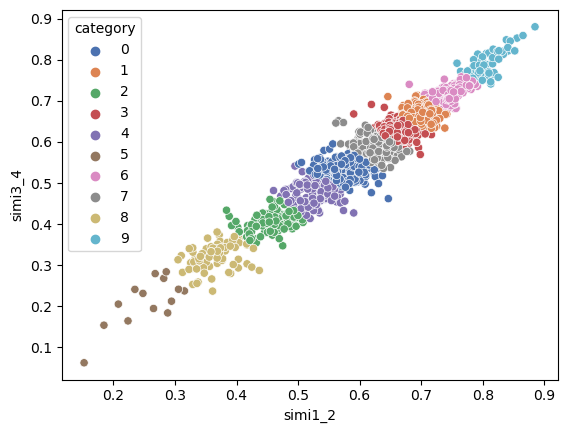

In [48]:
sns.scatterplot(data=result_df, x="simi1_2", y="simi3_4", hue="category",palette="deep")

# Output

### Display of top30 menus that are highly similar to the client menu

In [49]:
result_df.sort_values(by='simi_all', ascending=False).head(30)

,restaurant,type,name,description,similarity1,similarity2,similarity3,similarity4,simi1_2,simi3_4,simi_all,category
255,Kibo Sushi,Combinations,Assorted Sushi,"8pcs of California roll, 7pc of nigiri: tuna, ...",0.916927,0.852675,0.923452,0.836939,0.884801,0.880196,0.882499,9
256,Kibo Sushi,Combinations,Deluxe Assorted Sushi,"6pcs of Negihama maki, 12pc nigiri: tuna, salm...",0.866377,0.864254,0.858665,0.859207,0.865315,0.858936,0.862126,9
252,Kibo Sushi,Combinations,Sashimi Sushi Combo,"2pc sockeye salmon and 2pc tuna sashimi, 1pc s...",0.875147,0.836147,0.855694,0.849637,0.855647,0.852666,0.854156,9
253,Kibo Sushi,Combinations,Aburi Combo (6pc),"tuna, salmon, hotate, saba, ebi, and unagi tor...",0.839613,0.849545,0.835219,0.855491,0.844579,0.845355,0.844967,9
216,Kibo Sushi,Fancy Roll,Rainbow Roll,"Crabmeat, kappa inside; tuna, salmon, ebi, hok...",0.831976,0.844445,0.848470,0.848496,0.838211,0.848483,0.843347,9
946,Wooden Fish,ENTREES,Triple Bonanza,"Pan-fried 1 piece cod (4oz), 1 piece salmon (4...",0.861189,0.842568,0.835918,0.807290,0.851879,0.821604,0.836742,9
2047,Olde Yorke Fish & Chips,ENTREES,Triple Bonanza,"Pan-fried 1 piece cod (4oz), 1 piece salmon (4...",0.861189,0.842568,0.835918,0.807290,0.851879,0.821604,0.836742,9
1014,Yuwa Japanese Cuisine,Party Platters,Hoshi Oshi Combo,Hoshi oshi combo comes with four kinds of oshi...,0.833627,0.847729,0.826369,0.833073,0.840678,0.829721,0.835199,9
224,Kibo Sushi,Fancy Roll,Santa Roll,"2pcs of prawn tempura, cucumber, smoked salmon...",0.834337,0.847559,0.829440,0.813200,0.840948,0.821320,0.831134,9
1011,Yuwa Japanese Cuisine,Nigiri Combo,Aburi Set for Two,"Two pieces each of Salmon, toro, hamachi, hota...",0.835320,0.827547,0.846959,0.794146,0.831433,0.820552,0.825993,9


In [54]:
for index, row in result_df.sort_values(by='simi_all', ascending=False).head(30).iterrows():
    restaurant_name = row['restaurant']
    food_name = row['name']
    food_type = row['type']
    description = row['description']
    scores = row['simi_all']
    # Display the values to the client
    print("Restaurant Name:", restaurant_name)
    print("Food Name:", food_name)
    print("Type:", food_type)
    print("Description:", description)
    print("Scores:", scores)
    print("--------------------")  # Separator between rows

Restaurant Name: Kibo Sushi
Food Name: Assorted Sushi
Type: Combinations
Description: 8pcs of California roll, 7pc of nigiri: tuna, salmon, tako, ebi, tamago, hokkigai, and masago. Served with miso soup.
Scores: 0.8824986219406128
--------------------
Restaurant Name: Kibo Sushi
Food Name: Deluxe Assorted Sushi
Type: Combinations
Description: 6pcs of Negihama maki, 12pc nigiri: tuna, salmon, ebi, tamago, hokkigai, tako, hotate, saba, ika, unagi, tobiko, and ikura. Served with miso soup.
Scores: 0.8621256351470947
--------------------
Restaurant Name: Kibo Sushi
Food Name: Sashimi Sushi Combo
Type: Combinations
Description: 2pc sockeye salmon and 2pc tuna sashimi, 1pc sockeye salmon, 1pc tuna, and 1pc ebi nigiri half sockeye salmon and tuna maki
Scores: 0.8541564345359802
--------------------
Restaurant Name: Kibo Sushi
Food Name: Aburi Combo (6pc)
Type: Combinations
Description: tuna, salmon, hotate, saba, ebi, and unagi torched. served with miso soup
Scores: 0.8449668288230896
-------